In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb  # Should now import without error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [42]:
#Define constants
TARGET_COL = 'Weekly_Sales'
FREQ = 'W'
df = pd.read_csv(r"C:\Users\HomePC\Desktop\envoypathways\Walmart Data Analysis and Forcasting.csv")
try:
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
except ValueError:
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')
if df['Date'].isna().any():
    print("Warning: Some dates could not be parsed. Dropping rows with NaT.")
    df = df.dropna(subset=['Date'])

In [43]:
df = df.sort_values('Date')


In [44]:
def make_features(ts, freq='W'):
    df_feat = ts.copy()
    # Time-based features
    df_feat['Year'] = df_feat['Date'].dt.year
    df_feat['Month'] = df_feat['Date'].dt.month
    df_feat['Day'] = df_feat['Date'].dt.day
    df_feat['Week'] = df_feat['Date'].dt.isocalendar().week
    # Convert Holiday_Flag to binary
    if 'Holiday_Flag' in df_feat.columns:
        df_feat['Holiday_Flag'] = df_feat['Holiday_Flag'].astype(int)
    # Lag features (group by Store)
    df_feat['Lag_1'] = df_feat.groupby('Store')[TARGET_COL].shift(1)
    df_feat['Lag_2'] = df_feat.groupby('Store')[TARGET_COL].shift(2)
    # Rolling average (7-week window)
    df_feat['Rolling_Avg_7'] = df_feat.groupby('Store')[TARGET_COL].shift(1).rolling(window=7, min_periods=1).mean()
    # Drop rows with NaN values
    df_feat = df_feat.dropna()
    return df_feat

In [45]:
# Define ts as the DataFrame
ts = df.copy()

# Create features
feat_df = make_features(ts, freq=FREQ)
print(feat_df.head())

# Seasonal decomposition for one store (Store 1)
store_data = feat_df[feat_df['Store'] == 1][['Date', TARGET_COL]].set_index('Date')
if len(store_data) > 52:
    decomposition = seasonal_decompose(store_data[TARGET_COL], model='additive', period=52)
    feat_df.loc[feat_df['Store'] == 1, 'Trend'] = decomposition.trend.values
    feat_df.loc[feat_df['Store'] == 1, 'Seasonal'] = decomposition.seasonal.values
else:
    print("Not enough data for seasonal decomposition for Store 1.")


      Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
6294     45 2010-02-19     841264.04             0        31.27       2.745   
4006     29 2010-02-19     542399.07             0        31.96       2.747   
5722     41 2010-02-19    1052034.74             0        24.13       2.550   
3720     27 2010-02-19    1945070.33             0        32.44       2.909   
5865     42 2010-02-19     508794.87             0        58.22       2.915   

             CPI  Unemployment  Year  Month  Day  Week       Lag_1  \
6294  182.034782         8.992  2010      2   19     7   656988.64   
4006  131.637000        10.064  2010      2   19     7   529672.95   
5722  189.534100         7.541  2010      2   19     7  1075656.34   
3720  135.465778         8.237  2010      2   19     7  1745362.72   
5865  126.526286         9.765  2010      2   19     7   575709.96   

           Lag_2  Rolling_Avg_7  
6294   890689.51   1.082900e+06  
4006   538634.46   9.636070e+05  
57

In [35]:
# Handle missing values
feat_df = feat_df.fillna(feat_df.mean(numeric_only=True))


In [46]:
# Prepare features and target
features = ['Store', 'Year', 'Month', 'Day', 'Week', 'Holiday_Flag', 'Temperature', 
            'Fuel_Price', 'CPI', 'Unemployment', 'Lag_1', 'Lag_2', 'Rolling_Avg_7']
if 'Trend' in feat_df.columns:
    features += ['Trend', 'Seasonal']
X = feat_df[features]
y = feat_df[TARGET_COL]

In [ ]:
# Time-aware train-test split
dates = feat_df['Date'].unique()
train_dates, test_dates = train_test_split(dates, test_size=0.2, shuffle=False)
train_idx = feat_df['Date'].isin(train_dates)
test_idx = feat_df['Date'].isin(test_dates)
X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[test_idx]
y_test = y[test_idx]

In [47]:
dates = feat_df['Date'].unique()
train_dates, test_dates = train_test_split(dates, test_size=0.2, shuffle=False)
train_idx = feat_df['Date'].isin(train_dates)
test_idx = feat_df['Date'].isin(test_dates)
X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[test_idx]
y_test = y[test_idx]

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train Linear Regression with the imputed data
lr_model = LinearRegression()
lr_model.fit(X_train_imputed, y_train)
lr_pred = lr_model.predict(X_test_imputed)

In [51]:
# Train XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [52]:
# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

print("Model Evaluation:")
evaluate_model(y_test, lr_pred, "Linear Regression")
evaluate_model(y_test, xgb_pred, "XGBoost")

Model Evaluation:
Linear Regression - MAE: 58284.90, RMSE: 79124.61, R2: 0.98
XGBoost - MAE: 56272.06, RMSE: 76305.32, R2: 0.98


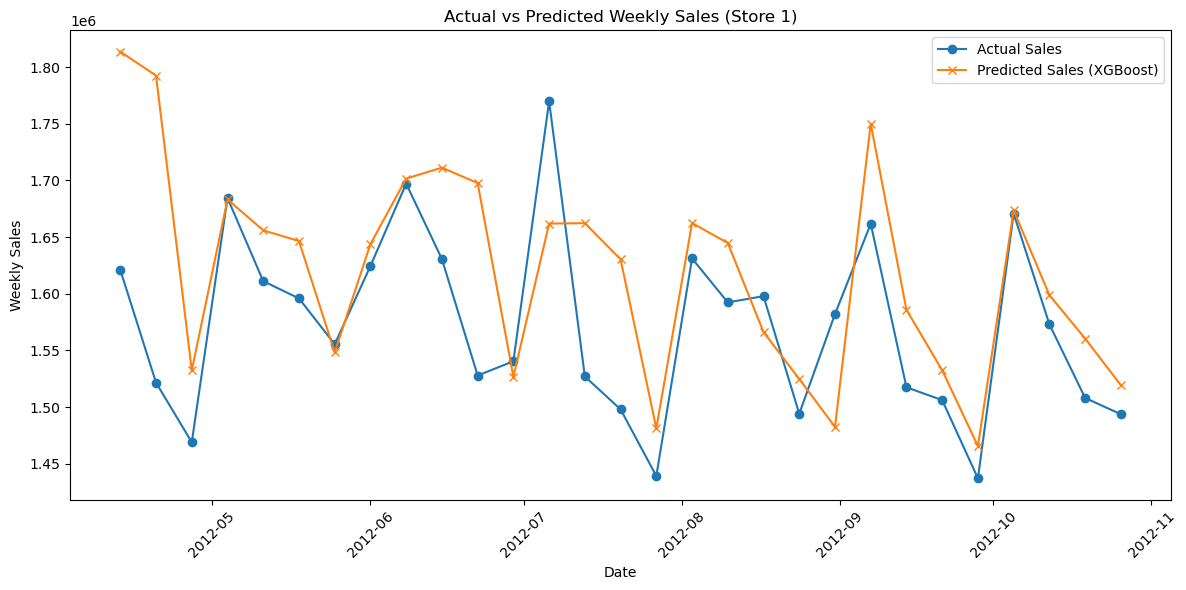

In [53]:
# Plot actual vs predicted sales for Store 1
plot_df = feat_df[test_idx][feat_df['Store'] == 1][['Date', TARGET_COL]].copy()
plot_df['Predicted'] = xgb_pred[feat_df[test_idx]['Store'] == 1]
plt.figure(figsize=(12, 6))
plt.plot(plot_df['Date'], plot_df[TARGET_COL], label='Actual Sales', marker='o')
plt.plot(plot_df['Date'], plot_df['Predicted'], label='Predicted Sales (XGBoost)', marker='x')
plt.title('Actual vs Predicted Weekly Sales (Store 1)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [55]:
# To forecast future sales (e.g., next week for Store 1)
# Example: Create a future row with estimated features (replace with actual values)
future_date = pd.to_datetime('2025-09-11')  # Example future date (weekly)
future_df = pd.DataFrame({
    'Store': [1],
    'Date': [future_date],
    'Holiday_Flag': [0],
    'Temperature': [70],  # Estimated
    'Fuel_Price': [4.0],  # Estimated
    'CPI': [250],  # Estimated
    'Unemployment': [5.0]  # Estimated
})
# Add time-based features
future_df['Year'] = future_df['Date'].dt.year
future_df['Month'] = future_df['Date'].dt.month
future_df['Day'] = future_df['Date'].dt.day
future_df['Week'] = future_df['Date'].dt.isocalendar().week

# Add missing 'Trend' and 'Seasonal' features
future_df['Trend'] = 1 
future_df['Seasonal'] = 2  

# For lag and rolling, use last known values from feat_df for Store 1
last_row = feat_df[feat_df['Store'] == 1].iloc[-1]
future_df['Lag_1'] = last_row[TARGET_COL]
future_df['Lag_2'] = feat_df[feat_df['Store'] == 1].iloc[-2][TARGET_COL]
future_df['Rolling_Avg_7'] = feat_df[feat_df['Store'] == 1][TARGET_COL].rolling(window=7).mean().iloc[-1]

# Predict
future_X = future_df[features]  # Ensure features match
future_pred = xgb_model.predict(future_X)
print(f"Predicted Weekly Sales for Store 1 on {future_date.date()}: {future_pred[0]:.2f}")

Predicted Weekly Sales for Store 1 on 2025-09-11: 1497896.38
